In [1]:
%%html
<style>.text_cell .rendered_html * {direction: rtl; text-align: right;}</style>

در این پروژه می خواهیم  قیمت های خودرو ها را پیش بینی کنیم. به این منظور از داده های سایت  دیوار استفاده شده است. از کتابخانه sickit learn برای مدل سازی مسئله استفاده می کنیم. در این پروژه مدل های   KNN, Linear Regression , Decision Tree  را پیاده سازی می کنیم و هایپر پارامتر های بهینه را برای آن پیادا می کنیم. و در ادامه این مدل ها را با یکدیگر مقایسه می کنیم.

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from hazm import *
from sklearn.feature_extraction.text import CountVectorizer
from datetime import datetime
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [3]:
df = pd.read_csv("vehicles.csv")

ابتدا پیش پردازش داده ها انجام می دهیم:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130443 entries, 0 to 130442
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   brand        120451 non-null  object 
 1   category     130443 non-null  object 
 2   created_at   130443 non-null  object 
 3   description  130443 non-null  object 
 4   image_count  130443 non-null  int64  
 5   mileage      120451 non-null  float64
 6   price        130443 non-null  int64  
 7   title        130443 non-null  object 
 8   year         120451 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 9.0+ MB


# سوال ۱ و ۲)

همان طور که مشاهده می شود بعضی از ویژگی ها تایپ  object دارند برای این که بتوانیم در مدل سازی از این ویژگی ها استفاده کنیم باید آن ها را به مقدار عددی تبدیل کنیم. نحوه انجام این کار بسیار اهمیت دارد و می تواند تاثیر زیادی در دقت مدل داشته باشد.

### drop NaN

ابتدا سطر هایی را که حداقل یکی از ویژگی های آن ها  NaN  است را حذف می کنیم.

In [5]:
df = df.dropna().reset_index(drop=True)

### category

پس از حذف کردن  NaN  ها در ستون  category  فقط یک مقدار  light  داریم بنابر این می توان این ستون را از ویژگی ها حذف کرد.

In [6]:
df["category"].value_counts()

light    120451
Name: category, dtype: int64

In [7]:
df = df.drop(columns=['category'], axis=1)

### year

ویژگی  year هم تایپ  objectدارد بنابر این ابتدا کاراکتر های غیر عددی را از  string  آن حذف می کنیم و سپس آن را به فرمت عددی آن تبدیل می کنیم.

In [8]:
df['year'] = df['year'].str.extract('(\d+)', expand=False)
df['year'] = df['year'].astype(int)

there are some -1 vlues for 'price' column we can delte rows with 'price' = -1 

#  سوال ۴)

برای مقادیر از دست رفته در دیتاست روش های مختلی داریم که دو مورد در ادامه توضیح داده شده است و در این جا حذف سطر مربوطه را انتخاب کردم.

### price

تعدادی قیمت -1  در داده ها وجود دارد که می توان میانگین داده های ستون price را با آن ها جایگزین کرد.

In [9]:
# df.replace(-1, df['price'].mean(), inplace=True)

34  داده داریم که مقدار قیمت آن ها -۱ است و تعداد کل داده ها حدود ۱۲۰ هزار است بنابر این بهترین راه حل پاک کردن این سطر ها است به دلیل این که به احتمال زیاد تاثیری در جواب و مدل سازی ندارند.

In [10]:
df = df[df['price'] != -1]

### created_at

مقادیر روز را به اعداد ۰ تا ۶ و ساعت را فرمت ۲۴ ساعت در می آوریم و به عنوان دو ستون جدید به داده ها اضافه می کنیم و ستون created_at قبلی را حذف می کنیم.

In [11]:
df['created_day'] = [time.strptime(i.split()[0], "%A").tm_wday  for i in df['created_at']]
df['created_time'] = [datetime.strptime(i.split()[1], '%I%p').hour for i in df['created_at']]
df = df.drop(columns=['created_at'], axis=1)

### brand: label encoder

در این روش به هر مقدار این ویژگی یک عدد اختصاص می دهد. مشکل این روش این است که به دلیل این که  به مقادیر مختلف عدد اختصاص می دهد مقدار این اعداد در واقعیت معنی خاصی نمی دهند ولی در مدل سازی ممکن است  ترتیب این مقادیر را تاثیر بدهد و خطای مدل بیشتر شود.  مثلا ممکن است به پراید عدد بیشتری نسبت به بی ام و بدهد و در مدل رگرسیون خطی این مقایسه به این معنی است که هر چه عدد مروط به برند ماشین پایین تر باشد قیمت آن بیشتر است در صورتی که در بقیه نمونه ها ممکن است این گونه نباشد.

In [12]:
le = LabelEncoder()
le.fit(df['brand'])
df['brand'] = le.transform(df['brand'])

In [13]:
list(le.classes_)

['ام\u200cوی\u200cام::MVM',
 'بنز::Mercedes-Benz',
 'بی\u200cام\u200cو::BMW',
 'تندر ۹۰::Tondar 90',
 'تویوتا::Toyota',
 'تیبا::Tiba',
 'دوو::Daewoo',
 'رانا::Runna',
 'رنو::Renault',
 'زانتیا::Citroen Xantia',
 'سایر',
 'سمند::Samand',
 'لیفان::Lifan',
 'نیسان::Nissan',
 'هیوندای (غیره)::Hyundai',
 'هیوندای سوناتا::Hyundai Sonata',
 'وانت',
 'پراید صندوق\u200cدار::Pride',
 'پراید هاچ\u200cبک::Pride',
 'پژو روآ / آر\u200cدی::RD/ROA',
 'پژو پارس::Peugeot Pars',
 'پژو ۲۰۶\u200d صندوق\u200cدار::Peugeot 206',
 'پژو ۲۰۶\u200d::Peugeot 206',
 'پژو ۴۰۵::Peugeot 405',
 'پیکان::Peykan',
 'کیا::Kia']

تبدیل برعکس مقادیر assign شده:


In [14]:
brand_inv = le.inverse_transform(df['brand'])
list(brand_inv)[:10]

['پژو ۴۰۵::Peugeot 405',
 'نیسان::Nissan',
 'سمند::Samand',
 'پژو ۴۰۵::Peugeot 405',
 'ام\u200cوی\u200cام::MVM',
 'پراید صندوق\u200cدار::Pride',
 'پراید هاچ\u200cبک::Pride',
 'سایر',
 'پراید صندوق\u200cدار::Pride',
 'پژو ۲۰۶\u200d::Peugeot 206']

In [15]:
df

,brand,description,image_count,mileage,price,title,year,created_day,created_time
1,23,پژو 2000فنی تازه تعمیر بدنه بدون خطو خش تخیف ب...,0,290000.0,8500000,پژو مدل 81 مشکی,1381,2,11
2,13,سلام.\nماشین کاملا سالم همه چی فابریک متور زد ...,3,175000.0,19500000,پاترول 2در,1372,2,13
3,11,سمند ال ایکس بدون رنگ تمامی سرویس ها انجام شده...,4,80000.0,23900000,سمند دوگانه کارخانه,1391,3,7
4,23,بیمه یکسال ده سال تخفیف دور رنگ شاسی پلمپ سالم,3,125000.0,8500000,پژو405 مدل84,1384,3,8
5,0,ام وی ام چهار سیلندر مدل 93 فنی سالم بدون رنگ ...,2,11000.0,18500000,ام وی ام 110 چهار سیلندر,1393,3,8
...,...,...,...,...,...,...,...,...,...
120443,23,پژو GLX تاکسی گردشی مدل ۱۳۹۰ بسیار کم کارکرد\...,1,120000.0,25900000,پژو 405 GLX تاکسی گردشی,1390,0,13
120445,3,فوق‌العاده سالم بدون رنگ دزدگیر ماجیکار شیشه ه...,2,173000.0,30000000,ال۹۰ E2,1390,1,14
120446,17,مدل 84 تمیز. بدون رنگ. سیستم صوتی. رینگ و لاست...,3,140000.0,11000000,پراید مدل 84 بدون رنگ,1384,1,17
120449,17,سند۲ برگ،بیمه تا برج$NUMتخفیفات بیمه 15 سال،مع...,4,123000.0,6900000,پراید 79 بسیار سالم,1379,3,15


### brand: one hot encoder 

در  one hot encoder  ها ستونی که  categorical است را می گیرد و به ازای هر مقدار که این مقادیر دارند یک ستون جدید ایجاد می کند که مقادیر آن ویژگی جدید برای هر داده به این صورت است که اگر نمونه آن ویژگی را داشت مقدار یک و در غیر این صورت مقدار صفر می گیرد. 

In [16]:
# df = pd.get_dummies(df, columns=['brand']).reset_index(drop=True)

# سوال۳)

### title and description

پس از امتحان کردن روش های مختلف کامنت شده بهترین جواب را بدون استفاده از  stemmer  و  lemmatizer می گیریم

In [17]:
STOPS = set(stopwords_list())
def clean_text(text):
    words = word_tokenize(text)
#     words = [w.replace('\u200c', '') for w in words]
#     words = [w.replace('-', '') for w in words]
#     words = [normalizer.normalize(w) for w in words]
#     words = [stemmer.stem(w) for w in words]
#     words = [lemmatizer.lemmatize(w) for w in words]
    words = [w for w in words if w.isalpha()]
#     STOPS = set(stopwords_list())
    words = [w for w in words if not w in STOPS]
    return words

به دلیل این که در ادامه برای استفاده از vectorizer داده های متنی باید به صورت جمله باشند پس از  clean کردن text کلمات را با استفاده از  space در کنار یکدیگر قرار می دهیم. (برای هر نمونه)

In [18]:
# normalizer = Normalizer()
# stemmer = Stemmer()
# lemmatizer = Lemmatizer()
t1 = time.time()
df['description'] = df['description'].apply(clean_text)
df['title'] = df['title'].apply(clean_text)
df['description'] = df['description'].apply(lambda x: " ".join(x))
df['title'] = df['title'].apply(lambda x: " ".join(x))
t2 = time.time()
print(t2-t1)

3.3181114196777344


### vectorizer

به تعداد  max_feature پرتکرار ترین کلماتی را که با استفاده از vectorizer  به دست می آوریم را در دیتا فریم نهایی قرار می دهیم.

In [19]:
t1 = time.time()

df = df.reset_index(drop=True)
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1), max_features=50)
vectorized = vectorizer.fit_transform(df['description'])
vectorized_desc = pd.DataFrame(vectorized.toarray().astype(np.uint8),
            index=['sentence '+str(i)
                   for i in range(1, 1+len(df['description']))],
            columns=vectorizer.get_feature_names())
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1), max_features=5)
vectorized = vectorizer.fit_transform(df['title'])
vectorized_title = pd.DataFrame(vectorized.toarray().astype(np.uint8),
            index=['sentence '+str(i)
                   for i in range(1, 1+len(df['title']))],
            columns=vectorizer.get_feature_names())
temp = df.drop(columns=['description', 'title'])
vectorized_title = pd.DataFrame(vectorized_title).reset_index(drop=True)
vectorized_desc = pd.DataFrame(vectorized_desc).reset_index(drop=True)
data = pd.concat([temp, vectorized_desc, vectorized_title], axis=1).reset_index(drop=True)
t2 = time.time()
print(t2-t1)

1.6059715747833252


In [20]:
data.head(10)

,brand,image_count,mileage,price,year,created_day,created_time,العاده,ای,باند,...,پراید,پژو,کارکرد,کاپوت,گلگیر,دوگانه,سفید,مدل,پراید,پژو
0,23,0,290000.0,8500000,1381,2,11,0,0,0,...,0,1,0,0,0,0,0,1,0,1
1,13,3,175000.0,19500000,1372,2,13,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,11,4,80000.0,23900000,1391,3,7,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,23,3,125000.0,8500000,1384,3,8,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,0,2,11000.0,18500000,1393,3,8,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,17,1,200000.0,11000000,1387,3,9,0,0,0,...,1,0,0,0,0,0,0,0,0,0
6,18,3,1.0,7800000,1380,4,4,0,0,0,...,0,0,0,0,0,0,0,1,1,0
7,10,1,17000.0,45000000,1393,4,12,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,17,3,250000.0,11000000,1388,5,12,0,0,0,...,0,0,0,0,0,1,0,0,1,0
9,22,4,120000.0,14800000,1386,5,13,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
Y = data['price']
X = data.drop(columns=['price'])

### mutual information

mutual information  بین دو ویژگی که در این جا بین ستون  های ویژگی و هدف مد نظر است، نشان دهنده  وابستگی آن ها می باشد. در این جا به این معنی است که هر ویژگی به چه میزان در قیمت تاثیر گذار است.  

In [22]:
t1 = time.time()

mi = mutual_info_classif(X, Y)
mi = pd.Series(mi)
mi.index = X.columns
mi.sort_values(ascending=False, inplace=True)

t2 = time.time()
print(t2-t1)

102.53135251998901


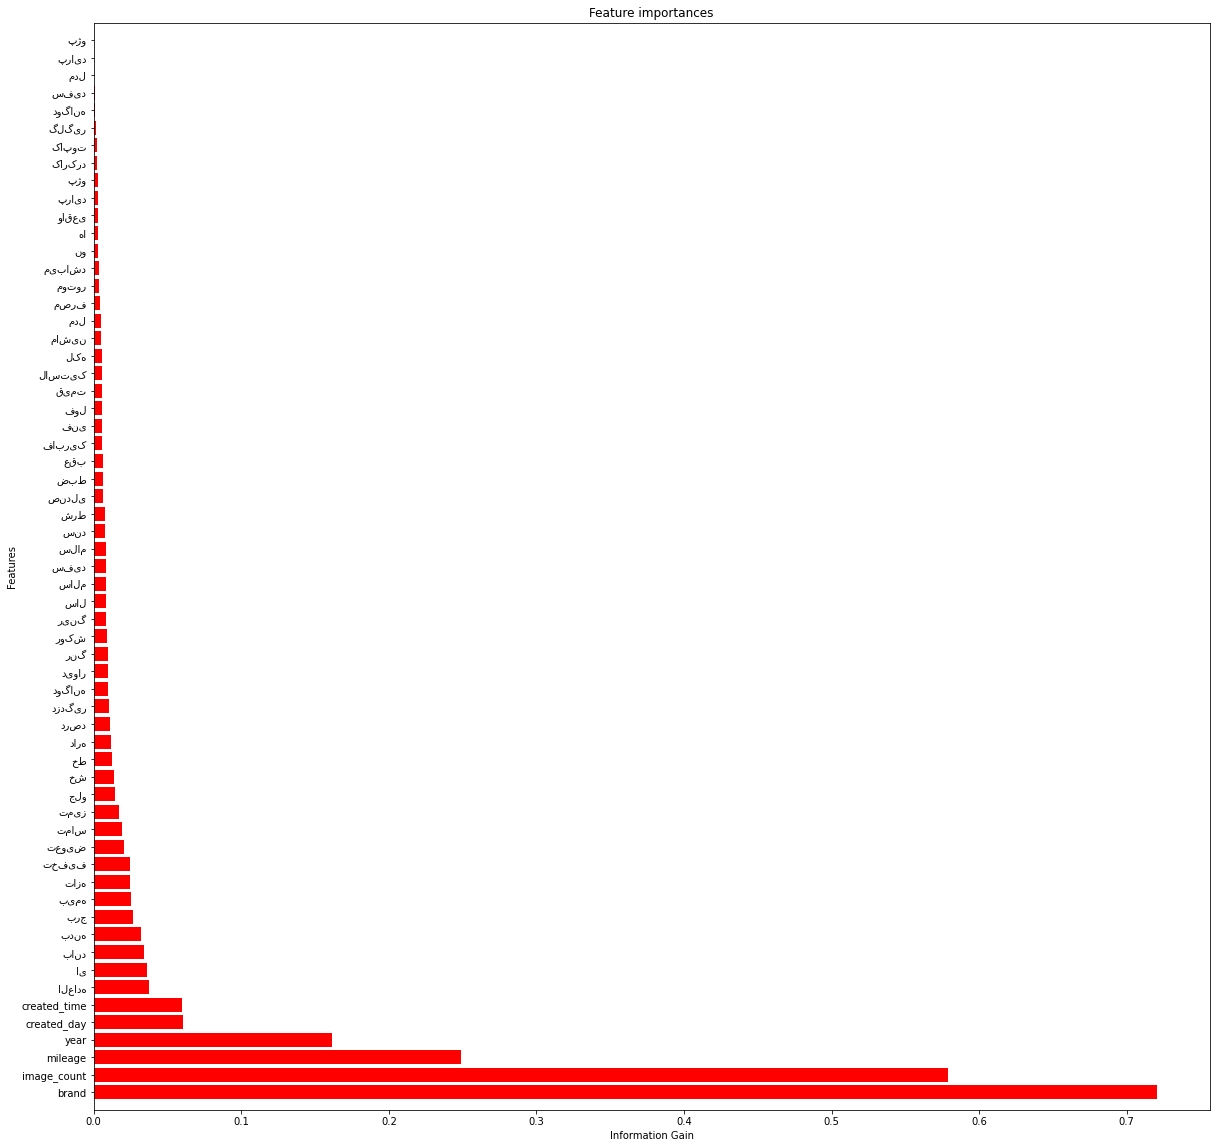

In [23]:
plt.figure(figsize=(20, 20))
plt.title("Feature importances")
plt.xlabel('Information Gain')
plt.ylabel('Features')
plt.barh(range(X.shape[1]), mi, color="r", align="center")
plt.yticks(range(X.shape[1]), X.columns)
plt.ylim([-1, X.shape[1]])
plt.show()

مشاهده می شود که قیمت خودرو ها بیشتر به برند وابسته اند.

 سپس داده تست و آموزشی را جدا می کنیم:

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

# سوال ۶)

# Decision Tree

یک روش یادگیری نظارتی  برای  classification  و regression به کار می رود.

max_depth: بیشترین عمقی که درخت باید داشته باشد. در حالت دیفالت عمق را تا زمانی که همه برگ ها فقط یک خروجی(به اندازه min_samples_leaf که به صورت دیفالت یک است) را بدهند  و یا همه برگ ها از مقدار min_sample split کم تر مقدار داشته باشند ادامه پیدا می کند. 
بیشترین مقدار آن می تواند یکی کم تر از تعداد داده های train  باشد. که هر چه مدل سازی به این حالت نزدیک تر باشد احتمال overfit  شدن زیاد تر است. در حالت کلی هر چه تعداد برگ ها و عمق درخت بیشتر شود مدل پیچیده تر و مستعد overfitting می شود.

از طرف دیگر عمق کم باعث underfit شدن مدل می شود یعنی حتا برای داده های آموزشی هم خطای زیادی داریم.

بنابر این برای عمق های مختلف خطا را محاسبه می کنیم و عمقی که کمترین خطا را داشت انتخاب می کنیم.

min_samples split: کمترین تعداد نمونه ای که یک نود داخلی نیاز دارد که بتوند  split  کند. در واقع هر چه این عدد کوچک تر باشدمدل پیچیده تر می شود.

In [79]:
t1 = time.time()

depths = np.arange(5, 15, 1)
error_train = []
error_test = []

for depth in depths:
    print("depth:", depth)
    dt = DecisionTreeClassifier(criterion="entropy", max_depth=depth, min_samples_split=30)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    train_pred = dt.predict(X_train)
    error_test.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    error_train.append(np.sqrt(metrics.mean_squared_error(train_pred, y_train)))

t2 = time.time()
print(t2-t1)

depth: 5
depth: 6
depth: 7
depth: 8
depth: 9
depth: 10
depth: 11
depth: 12
depth: 13
depth: 14
27.891234874725342


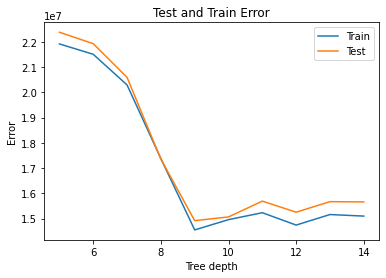

In [81]:
plt.figure()
plt.plot(depths, error_train, label="J Train")
plt.plot(depths, error_test, label="J Test")
plt.legend(["Train", "Test"])
plt.ylabel('Error')
plt.xlabel('Tree depth')
plt.title('Test and Train Error')
plt.show()

با توجه به نمودار بالا تا عمق 9 خطا در حال کاهش است ولی از عمق 9 به بعد خطای داده های تست افزایش می یاد و خطا ها واگرا می شوند. در این جا  overfitting رخ داده است. یعنی خطا برای داده train خیلی کم می شود و به سمت صفر میل می کند ولی برای داده تست زیاد می شود و دلیل آن فیت شدن مدل به داده های آموزشی است و دیگر برای مقادیر جدید پیش بینی خوبی انجام نمی دهد.

بنابر این عمق 9 را انتخاب می کنیم.

In [82]:
clf = DecisionTreeClassifier(criterion="entropy", max_depth=9,  min_samples_split=30)
clf.fit(X_train, y_train)
# tree.plot_tree(clf)
# plt.show()
y_pred = clf.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Mean Absolute Error: 5277281.834007707
Mean Squared Error: 222486204874478.53
Root Mean Squared Error: 14915971.469350513
Accuracy: 0.08439306358381503


# KNN

الگوریتم معمولا برای classification استفاده می شود و این الگوریتم کلاس داده ها را بر اساس k  داده اطراف آن مدل سازی می کند یعنی هنگامی که داده جدیدی به آن می دهیم کلاس آن را بر اساس کلاس k داده اطراف آن تخمین می زند.

بنابر این به دست آوردن مقدار مناسب برای پارامتر k اهمیت زیادی دارد.

برای به دست آورن k  داده نزدیک نیاز به محاسبه کردن فاصله داده ها می باشد که از سه طریق Euclidean Distance, Manhattan Distance, and Minkowski Distance قابل انجام است.  sickit learn  به صورت دیفالت از Euclidean  استفاده می کند.

In [28]:
t1 = time.time()

df_k = df.reset_index(drop=True)
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1), max_features=20)
vectorized = vectorizer.fit_transform(df_k['description'])
vectorized_desc = pd.DataFrame(vectorized.toarray().astype(np.uint8),
            index=['sentence '+str(i)
                   for i in range(1, 1+len(df_k['description']))],
            columns=vectorizer.get_feature_names())
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1), max_features=3)
vectorized = vectorizer.fit_transform(df_k['title'])
vectorized_title = pd.DataFrame(vectorized.toarray().astype(np.uint8),
            index=['sentence '+str(i)
                   for i in range(1, 1+len(df_k['title']))],
            columns=vectorizer.get_feature_names())
temp = df_k.drop(columns=['description', 'title'])
vectorized_title = pd.DataFrame(vectorized_title).reset_index(drop=True)
vectorized_desc = pd.DataFrame(vectorized_desc).reset_index(drop=True)
data_ = pd.concat([temp, vectorized_desc, vectorized_title], axis=1).reset_index(drop=True)

data_k = data_.loc[:30000, :]
Y_k = data_k['price']
X_k = data_k.drop(columns=['price'])
X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(X_k, Y_k, test_size=0.2, shuffle=True)
t2 = time.time()
print(t2-t1)

1.5121283531188965


k=  10
k=  20
k=  30
k=  40
k=  50
95.71282887458801


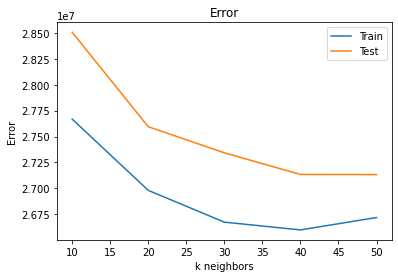

In [29]:
t1 = time.time()

ks = np.arange(10, 60, 10)
error_train_k = []
error_test_k = []

for k in ks:
    print('k= ', k)
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_k, y_train_k)
    y_pred_k = knn.predict(X_test_k)
    train_pred_k = knn.predict(X_train_k)
    error_test_k.append(np.sqrt(metrics.mean_squared_error(y_test_k, y_pred_k)))
    error_train_k.append(np.sqrt(metrics.mean_squared_error(train_pred_k, y_train_k)))
    
t2 = time.time()
print(t2-t1)
plt.plot(ks, error_train_k, label="J Train")
plt.plot(ks, error_test_k, label="J Test")
plt.legend(["Train", "Test"])
plt.ylabel('Error')
plt.xlabel('k neighbors')
plt.title('Error')
plt.show()

k=  3
k=  4
k=  5
k=  6
k=  7
k=  8
k=  9
122.98464155197144


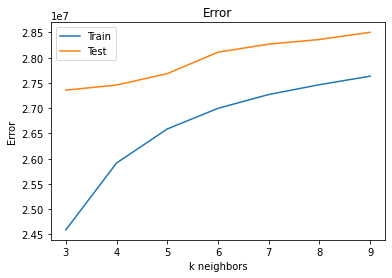

In [30]:
t1 = time.time()

ks = np.arange(3, 10, 1)
error_train_k = []
error_test_k = []

for k in ks:
    print('k= ', k)
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_k, y_train_k)
    y_pred_k = knn.predict(X_test_k)
    train_pred_k = knn.predict(X_train_k)
    error_test_k.append(np.sqrt(metrics.mean_squared_error(y_test_k, y_pred_k)))
    error_train_k.append(np.sqrt(metrics.mean_squared_error(train_pred_k, y_train_k)))
    
t2 = time.time()
print(t2-t1)
plt.plot(ks, error_train_k, label="J Train")
plt.plot(ks, error_test_k, label="J Test")
plt.legend(["Train", "Test"])
plt.ylabel('Error')
plt.xlabel('k neighbors')
plt.title('Error')
plt.show()

با توجه به نمودار بالا gap  بین خطای تست و ترین هرچه تعداد نونه های آموزشی را بیشتر کنیم، کمتر می شود. و به نظر می رسد که ۳۰ عدد مناسبی برای  k  .باشد. از ۳۰ به بعد هم خطای تست و هم ترین کاهش میابد.  
ولی شیب تغییرات بسیار کم است و به محاسبات پیچیده ای که باید انجام شود نمی ارزد

هرچه مقدار k را بیشتر کنیم خطا کمتر می شود

کم ترین مقدار k  برابر با یک است که به معنی این می باشد که همه داده ها در یک کلاس قرار دارند. در این صورت خطای train خیلی کم (صفر) است و خطای  test بسیار زیاد است  در واقع مدل underfit است. 

بیشترین مقدار k همان تعداد نمونه های آموزشی می باشد یعنی برای هر نمونه آموزشی یک کلاس درنظر گرفته می شود و هرچه مدل به این حالت نزدیک تر باشد احتمال  overfit شدن بیشتر است. و خطا بیشتر می شود.

In [85]:
t1 = time.time()
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
t2 = time.time()
print(t2-t1)

Root Mean Squared Error: 26764819.98583765
44.62276649475098


#  سوال ۵)

# Linear Regression

 یک مدل خطی برای داده های آموزشی به دست می آورد. در این روش سعی در پیدا کردن وزن های بهینه برای مدل دارد. به گونه ای که خطای بین مقدار پیش بینی شده و مقدار واقعی حداقل شود. و در نتیجه خطا برای داده های تست هم کاهش یابد.

   اگر داده های آموزشی کمی در اختیار داشته باشیم ممکن است مدل underfit  شود.  
  به طور معمول بهترین راه این است که حدود ۲۰ درصد داده ها را به عنوان داده تست در نظر بگیریم. که هم بتوانیم مدل را به خوبی آموزش دهیم و هم دقت را برای داده های جدید به خوبی ارزیابی کنیم.

 ولی به طور کلی پس از چند بار ران کردن به نظر می رسد که خطا در بازه بزرگی متغیر است و مقدار خطا robust  نیست. به نظر می رسد که چون تعداد داده های تست بسیار کم است گاهی  overfit می شود و دقت کاهش میابد و گاهی به طور شانسی داده های تست را خوب انتخاب می کند و خطا کم تر می شود. از طرفی چون فقط داریم خطا را بررسی میکنیم و تعداد داده های تست را بسیار کم کرده ایم طبیعی است که اگر داده ها خیلی بد انتخاب نشوند، مجموع خطا ها کم تر شود. ولی همان طور که گفته شد این کم بودن خطا ها مقاوم در برابر داده های دیگر نیست.

در ادامه به ازای ۱۰ iteration و برای test ratio ۰.۰۲  خطا را رسم می کنیم:

In [64]:
data_l = pd.get_dummies(data, columns=['brand']).reset_index(drop=True)
Y_l = data_l['price']
X_l = data_l.drop(columns=['price'])
iterations = np.arange(1, 10, 1)
error_train_l = []
error_test_l = []
for i in iterations:
    print('itr= ', i)
    X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_l, Y_l, test_size=0.02, shuffle=True)
    model = LinearRegression()
    model.fit(X_train_l, y_train_l)
    y_pred_l = model.predict(X_test_l)
    train_pred_l = model.predict(X_train_l)
    error_test_l.append(np.sqrt(metrics.mean_squared_error(y_test_l, y_pred_l)))
    error_train_l.append(np.sqrt(metrics.mean_squared_error(train_pred_l, y_train_l)))

itr=  1
itr=  2
itr=  3
itr=  4
itr=  5
itr=  6
itr=  7
itr=  8
itr=  9


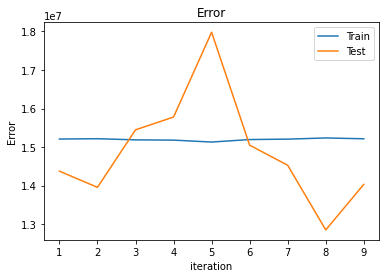

In [65]:
plt.plot(iterations, error_train_l, label="J Train")
plt.plot(iterations, error_test_l, label="J Test")
plt.legend(["Train", "Test"])
plt.ylabel('Error')
plt.xlabel('iteration')
plt.title('Error')
plt.show()

برای پیدا کردن بهترین تعداد تکرار بازه ۰ تا ۱ را به ۱۰ قسمت تقسیم می کنیم و الگوریتم را پیاده سازی می کنیم:

In [67]:
data_l = pd.get_dummies(data, columns=['brand']).reset_index(drop=True)
Y_l = data_l['price']
X_l = data_l.drop(columns=['price'])
ratios = np.arange(0.001, 1, 0.1)
error_train_l = []
error_test_l = []
for r in ratios:
    print('itr= ', r)
    X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_l, Y_l, test_size=r, shuffle=True)
    model = LinearRegression()
    model.fit(X_train_l, y_train_l)
    y_pred_l = model.predict(X_test_l)
    train_pred_l = model.predict(X_train_l)
    error_test_l.append(np.sqrt(metrics.mean_squared_error(y_test_l, y_pred_l)))
    error_train_l.append(np.sqrt(metrics.mean_squared_error(train_pred_l, y_train_l)))

itr=  0.001
itr=  0.101
itr=  0.201
itr=  0.30100000000000005
itr=  0.401
itr=  0.501
itr=  0.6010000000000001
itr=  0.7010000000000001
itr=  0.801
itr=  0.901


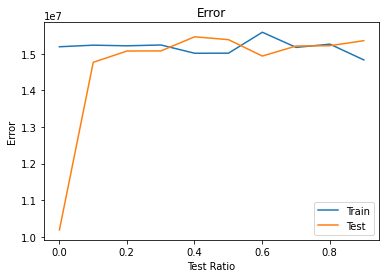

In [69]:
plt.plot(ratios, error_train_l, label="J Train")
plt.plot(ratios, error_test_l, label="J Test")
plt.legend(["Train", "Test"])
plt.ylabel('Error')
plt.xlabel('Test Ratio')
plt.title('Error')
plt.show()

همان طور که توضیح داده شد اگر حدود ۲۰ درصد به بالا را داده تست درنظر بگیریم الگوریتم underfit می شود و دیگر خطا را به درستی تشخیص نمی دهد.

In [72]:
data_l = pd.get_dummies(data, columns=['brand']).reset_index(drop=True)
Y_l = data_l['price']
X_l = data_l.drop(columns=['price'])
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_l, Y_l, test_size=0.1, shuffle=True)
model = LinearRegression()
model.fit(X_train_l, y_train_l)
y_pred_l = model.predict(X_test_l)
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_l, y_pred_l)))

Root Mean Squared Error: 14613854.590727167


# سوال ۷)

# Random Forest

n_estimators:  نشان دهنده تعداد درخت ها می باشد هر چه تعداد درخت ها بیشتر باشد مدل مقاوم تر است و واریانس آن کم تر است اما زمان محاسبه داده های آموزشی زیاد است.  برای مشخص کردن این هایپر پارامتر باید به تعداد نمونه های آموزشی و همچنین تعداد ویژگی های هر نمونه نگاه کنیم. به دلیل این که اگر به طور مثال تعداد ویژگی ها بسیار زیاد باشد ولی تعداد درخت ها کم باشد در این صورت درخت ها همه ویژگی ها را پوشش نمی دهد و ممکن است بعضی از ویژگی های مهم را از دست  بدهیم.  

همچنین اگر تعداد نمونه های آموزشی زیاد باشند ولی از تعداد درخت های کمی استفاده کنیم اتفاق مشابهی می افتد.

این الگوریتم به ندرت  overfit  می شود بنابر این معمولا هر چه تعداد درخت ها را بیشتر کنیم خطا کمتر و دقت بیشتر می شود ولی باید به حجم محاسباتی هم توجه داشته باشیم.

Number of random features: تعداد فیچر هایی که در هر نود برای split  کردن در نظر می گیرد.

The Criteria on which to split on at each node of the trees: روشی که در هر نود به کار می برد و  split  را بر اساس آن انجام می دهد.
دو حالت Gini  و Entropy دارد.

در این سوال از RandomForestRegressor  استفاده کرده ام. در این مدل سازی از چند درخت تصمیم استفاده می ود که هر کدام از آن ها بر روی زیر مجموعه ای از داده ها مدل می شوند و در نهایت میانگین آن ها به عنوان مدل نهایی انتخاب می شود.   

با استفاده از random_grid    بازه ای از مقادیر مختلف را به آن می دهیم و با توجه بهRandomizedSearchCV  بهترین مقادیر را انتخاب می کند.

In [76]:
Y = data['price']
X = data.drop(columns=['price'])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

n_estimators = [int(x) for x in np.linspace(start = 10, stop = 50, num = 5)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(8, 50, num = 5)]
max_depth.append(None)
min_samples_split = [5, 10, 20, 40]
min_samples_leaf = [2, 4, 8, 10, 20]
bootstrap = [True, False]
# criterion = ['mse', 'mae']
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
                }
print(random_grid)
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator=rf, param_distributions = random_grid, n_iter = 10, cv = 4, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)
y_pred = rf_random.predict(X_test)
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

{'n_estimators': [10, 20, 30, 40, 50], 'max_features': ['auto', 'sqrt'], 'max_depth': [8, 18, 29, 39, 50, None], 'min_samples_split': [5, 10, 20, 40], 'min_samples_leaf': [2, 4, 8, 10, 20], 'bootstrap': [True, False]}
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Root Mean Squared Error: 11660500.480838591


بایاس: تفاوت بین میانگین پیش بینی های مدل و مقادیر واقعی کلاس ها می باشد. مدلی که بایاس بالا داشته باشد توجه کم تری به داده های آموزشی دارد و درواقع مدل ساده تری ایجاد می کند که مستعد underfitting است. در این موارد خطای داده تست و آموزشی هر دو زیاد است ولی می دانیم همیشه خطای تست ازtrainf بیشتر است.

واریانس: 
    مدل با واریانس بالا به این معنی است که توجه زیادی به داده آموزشی دارد، مدل پیچیده تری ایجاد می کند که خطای داده آموزشی را کاهش دهد . generalize  نمی باشد و برای داده های جدید خطای زیادی دارد.و در واقع مدل overfit است

انتظار داریم  با توجه به تعریف بایاس و واریانس مدل تجمیعی به نسبت درخت تصمیم (یک) عملکرد بهتری داشته باشد زیرا در این حالت هر نمونه در عین حال که در مدل سازی نقش دارد، به نظر می رسد که با میانگین گیری به نوعی نقش پایدار سازی را دارد بنابر این از overfit شدن جلوگری می کند و از طرف دیگر تعداد نمونه ها و فیچر ها را هم اگر معقول انتخاب کنیم underfit نخواهد شد و در نتیجه بایاس بالا و یا واریانس بالا نخواهیم داشت.

# نتیجه گیری:

برای مسئل طبقه بندی، در هر مدل سازی باید ابتدا داده ها را به خوبی شناخت، روابط و وابستگی های بین آن ها و تاثیر هر کدام در تشخیص کلاس را به دست آورد. استخراج ویژگی های درست از نمونه ها بسیار اهمیت دارد و می تواند مدل سازی را تحت تاثیر قرار دهد.  

بهترین روش پیدا کردن هایپر پارامتر های مدل بررسی مقدار های مختلف و در نهایت انتخاب پارامتر بهینه( پارامتری که خطا را کمینه می کند) می باشد.

In [91]:
import os
os.system('jupyter nbconvert --to html AI_CA4_810896059.ipynb')

0